# Generate image with calcifications for Ansys
Image range is 0-100 mm -> 1 element is 1 mm. Once he image is generated, it can be saved into svg for further convertion into dxf.

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from typing import NamedTuple
from typing import Optional
from shapely.ops import unary_union
from matplotlib.patches import Circle
from rtree import index
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd

In [31]:
frame_w = 100
frame_h = 100
num_attempts = 5000

In [45]:
class Calcification(NamedTuple):
    x: float
    y: float
    radius: float

In [49]:
def generate_circle(max_diameter):
    x = random.randint(0, frame_w)
    y = random.randint(0, frame_h)
    di = random.uniform(1.0, max_diameter)
    return Calcification(x, y, di/2)

In [50]:
def chceck_intersection(circle_1, circle_2):
    x1, y1, r1 = circle_1
    x2, y2, r2 = circle_2
    
    d = math.sqrt((x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2))
    if (d <= r1 - r2):
        return 0
    elif(d <= r2 - r1):
        return 0
    elif(d < r1 + r2):
        return 0
    elif(d == r1 + r2):
        return 0
    else:
        return 1

In [51]:
def generate_calcifications(max_di: int, do_overlay: bool = False):    
    result_circles = [Calcification(0, 0, 0)] 
    overlap = 0
    for _ in range(num_attempts):
        new_circle = generate_circle(max_di)
        if new_circle in result_circles:
            continue
        for i, circle in enumerate(result_circles, start=1):
            keep = chceck_intersection(new_circle, circle)
            if keep and i < len(result_circles):
                continue
            elif keep and i == len(result_circles):
                result_circles.append(new_circle)
                break
            elif not keep and do_overlay and overlap % 10 == 0:
                result_circles.append(new_circle)
                overlap += 1
                break
            else:
                overlap += 1
                break

        if (overlap % 500) == 0:
            max_di = max_di - 0.5
        if max_di < 1:
            max_di = 1
    return result_circles

In [52]:
calcification = generate_calcifications(max_di=10, do_overlay=True)

In [53]:
def draw_calcifications(calc: list[tuple], save_dxf: bool = True) -> None:    
    mm = 1 / (2.54 * 10)
    fig, ax = plt.subplots(figsize=(100*mm, 100*mm))
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim(0, frame_w)
    ax.set_ylim(0, frame_h)

    for circle in calc:
        x, y, r = circle
        circ = plt.Circle((x, y), r, fill=False)
        ax.add_patch(circ)
    if save_dxf:
        plt.savefig('calcifications.eps')
        ! pstoedit -dt -f 'dxf:-polyaslines -mm' calcifications.eps calcifications.dxf

pstoedit: version 3.78 / DLL interface 108 (built: Sep 11 2022 - release build - g++ Apple LLVM 13.1.6 (clang-1316.0.21.2.5) - 64-bit) : Copyright (C) 1993 - 2021 Wolfgang Glunz


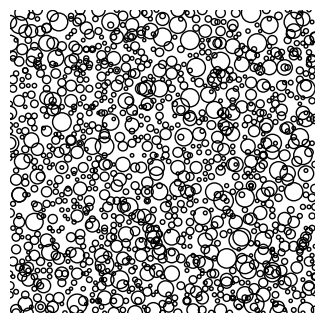

In [54]:
draw_calcifications(calcification)

# Overlay
Jakmile bude požadavek i na overlay potenciální kalcifikací pro vytvoření složitějších objektů.

In [55]:
# Vytvoření polygon objetu (shapely) z jednotlivých kalcifikací, které mám definovány jenom jako souřadnice a poloměr
def get_polygons(calc: list[tuple]) -> list[Polygon]:
    grid_cells =  []
    for calc in calcification:
        x, y, r = calc
        circle = Circle((x, y), r)
        vertices = circle.get_verts()
        grid_cells.append(Polygon(vertices))
    return grid_cells

## Overlay - Rtree
example from https://stackoverflow.com/questions/14697442/faster-way-of-polygon-intersection-with-shapely

Nakonec jsem nešel tímto směrem, protože to sice dokáže hledat z indexu objekty, které se překrávají, ale udělá to první čtverec kolem - R=rectangle a kontroluje to překryv až jich. To Způsobuje, že to najde více překryvů, než by mělo a nezůstane tam potom ten obvod.

## Overlay - GeoPandas
https://stackoverflow.com/questions/73547342/how-to-find-intersecting-polygons-and-union-them-using-geopandas

Zde jde také udělat `unary_union` překrývajících se polygonů a zdá se, že algoritmus pro to je jiný než Rtree, takže to dokáže krásně ponechat ten požadovaný obvod překrývajících se objektů.

Je to taky celkem rychlé, protože je to zaindexováno a zase to asi hledá z těch souřadnic.

In [56]:
def draw_overlay(calc: list[Polygon], save_dxf: bool = True):
    gdf = gpd.GeoDataFrame(
        dict(
            id=range(1, len(calc)+1),
            geometry=calc
        )
    )
    # merge polygon with intersection
    gdf_merge = gdf.dissolve().explode(index_parts=True)
    gdf_clean = gpd.sjoin(gdf_merge, gdf, how='inner', predicate='intersects')
    # get them back to separate objects
    gdf_clean['AREA'] = gdf_clean['geometry'].apply(lambda x: x.area)
    gdf_clean = gdf_clean.groupby('AREA')
    gdf_clean = gdf_clean.agg({'geometry': 'first', 'id_right': 'min'})
    gdf_clean['id'] = gdf_clean['id_right']
    gdf_clean = gdf_clean[['id', 'geometry']].reset_index(level='AREA').drop(columns=['AREA'])
    
    mm = 1 / (2.54 * 10)
    fig, ax = plt.subplots(figsize=(100*mm, 100*mm))
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim(0, frame_w)
    ax.set_ylim(0, frame_h)

    for _, item in gdf_clean.iterrows():
        ax.plot(*item['geometry'].exterior.xy)
    
    if save_dxf:
        plt.savefig('calcifications.eps')
        ! pstoedit -dt -f 'dxf:-polyaslines -mm' calcifications.eps calcifications.dxf

pstoedit: version 3.78 / DLL interface 108 (built: Sep 11 2022 - release build - g++ Apple LLVM 13.1.6 (clang-1316.0.21.2.5) - 64-bit) : Copyright (C) 1993 - 2021 Wolfgang Glunz


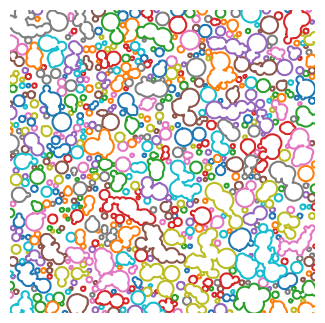

In [57]:
# draw overlayed calcifications
draw_overlay(get_polygons(calcification))

## Komentáře

- vygeneruj kruh
- zkontroluj, zda není překryv (existují na to kontroly)
- jestli ne, tak jej přidej, jestli ano, tak běž dále.
- takhle bych zkusil několik iterací, kde nejtěžší bude asi kontrola nového vs již vytvořených kruhů


### Overlap
- zkusit přidat i možnost, kdy se některé kruhy mohou kombinovat? Prostě zahrnutí spojených kacifikací jako další varianta
- bude to možné udělat nějak přes indexování sapolečných kruhů? Ať je potom nějak spojím dohromady třeba.. 
- https://stackoverflow.com/questions/34475431/plot-unions-of-polygons-in-matplotlib
    - zde řeší podobnou věc, kde první vytvoří `union` a pak to přenesou jako fill
    
- spatial join GeoPandas??

### Výpočtový model
- oblast celá jako kámen
- oblast jako náhodně distribuované kalcifikace -> několik výpočtů s jiným generováním pro nějakou statistiku
- oblast u uvažováním overlay